<a href="https://colab.research.google.com/github/ju-sants/Desafios-DNC/blob/main/Desafio_6_Classifica%C3%A7%C3%A3o_(v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settings

## Libraries

In [ ]:
%%capture
!pip install lime

In [42]:
# Data Wrangling
import pandas as pd
import numpy as np
import random

# Data viz
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split

# Model interpretability
from lime.lime_tabular import LimeTabularExplainer

## Functions

In [ ]:
# Usada para exibir as categorias das variáveis categóricas num DataFrame

def categorical_unique(df, max_values):
  # inicializando uma cópia do DataFrame informado e criando uma lista com o
  # nome das variáveis categoricas
  df = df.copy()
  cat_features = df.select_dtypes(exclude='number').columns

  # iterando sobre cada coluna categórica, utilizando 'cat_features'
  for column in cat_features:

    # para cada coluna, pritamos seu nome com o parâmetro end='', para que
    # os próximos prints fiquem na mesma linha no output.
    # inicializamos 'value_count' com 0, a variável servirá para limitar colunas
    # com muitos valores únicos

    print(f'{column}: ', end='')
    value_count = 0

    for value in df[column].unique():

      # acessamos os valores unicos de cada coluna com .unique()

      value_count += 1

      if value_count > max_values:
        # caso value_count for maior que o parametro max_values
        # a iteração para.

        print('...')
        break

      elif value == df[column].unique()[-1]:

          # se o valor for o último valor único da coluna
          # printamos o valor com um '.'

          print(f'{value}.')
          break

      else:

          # senão printamos o valor com ','

          print(f'{value}, ', end='')


# Usada para plotar a frequência das categorias para cada variável categórica

def categorical_freq_plot(df):

    # importando pyplot para os gráficos
    from matplotlib import pyplot as plt

    # inicializando uma cópia do DataFrame e uma lista com os nomes
    # das variáveis categoricas

    df = df.copy()
    cat_features = df.select_dtypes(exclude='number').columns

    # iterando sobre cada coluna na lista

    for column in cat_features:

      # criando uma tabela auxiliar para guardar as categorias
      # e suas contagens, para posterior plotagem

      aux = df[column].value_counts()
      plt.bar(aux.index, aux.values)
      plt.title(f'Distribuição dos valores de {column}')
      plt.xticks(rotation=45)
      plt.show()

def cross_avaliate(models: list, X, y, avaliator, score_type='roc_auc', sort_by=0):

    # importações necessárias
    from sklearn.model_selection import cross_val_score
    import pandas as pd

    # a função tem dois caminhos principais dependendo do parâmetro score_type
    # se para score_type for passado apenas uma string com a metrica, ou se for passado
    # uma lista de strings, contendo as métricas.

    # caso for uma lista de métricas:

    if type(score_type).__name__ == 'list':

      # primeiro inicializamos a coluna 'Models' do DataFrame
      # que será retornado ao usuário.

      dict_df = {'Models': []}

      # após, para cada metrica inicializamos uma coluna ao DataFrame
      for score in score_type:

        dict_df[score] = []

      # e para cada modelo na lista de modelos adicionamos seu nome
      # e calculamos as métricas
      for model in models:

        dict_df['Models'].append(type(model).__name__)

        for score in score_type:
          scoring = cross_val_score(model, X, y, cv=avaliator, scoring=score)
          dict_df[score].append(scoring.mean())

      # por fim criamos o DataFrame e retornamos ao usuário
      df = pd.DataFrame(dict_df)

      return df.sort_values(by=score_type[sort_by], ascending=False).reset_index(drop=True)

    # caso for apenas uma string com a metrica desejada
    else:

      # inicializando as listas necessárias para o DataFrame
      scores = []
      models_for_frame = []

      # calculando métricas para cada modelo
      for model in models:

        scoring = cross_val_score(model, X, y, cv=avaliator, scoring=score_type)
        scores.append(scoring.mean())
        models_for_frame.append(type(model).__name__)

      # e por fim criando e retornando o DataFrame
      df = pd.DataFrame({
          'Models': models_for_frame,
          f'{score_type}': scores
      })

      return df.sort_values(by='Avaliation', ascending=False).reset_index(drop=True)


# Utilizado para pegar as importâncias das features de um modelo de arvore
def feature_importance_tree(model_fitted, features_list):
  # Importações
  import pandas as pd

  # Criando lista de importâncias
  importances = model_fitted.feature_importances_

  # Transformando em um DataFrame
  df = pd.DataFrame({
      'Features': features_list,
      'Importance': importances
  })

  # Retornando-o com os valores da importância em ordem Decrescente e com o index normalizado
  return df.sort_values(by='Importance', ascending=False).reset_index(drop=True)



# utilizada para automatizar a visualização das métricas de seus modelos em um tipo de Cross-validation desejado
def param_search(models: list, list_param_grids: list, searcher, X, y, scoring='roc_auc', n_iter=10, n_jobs=-1):

    # importações
    import pandas as pd

    # inicializando listas posterior criação de um DataFrame
    best_estimators = []
    scores = []
    adjusted_params = []

    # iterando sobre cada modelo e os parametros passados para cada um deles
    # realizando a busca e guardando o nome do modelo no qual foi aplicado a busca
    # seus parâmetros padrão e os ajustados pela busca.
    for model, param_grid in zip(models, list_param_grids):

      # Verificando o tipo de 'Searcher', se tiver o atributo 'n_iter' é o RandomizedSearchCV, caso não
      # é o GridSearchCV.
      if hasattr(searcher, 'n_iter'):
        search = searcher(model, param_grid, n_iter=n_iter, n_jobs=n_jobs, scoring=scoring).fit(X, y)

      else:
        search = searcher(model, param_grid, n_jobs=n_jobs, scoring=scoring).fit(X, y)

      best_params = search.best_estimator_.get_params()
      default_params = model.get_params()

      # a coluna Adjusted Parameters é criada com este dict comprehension, que adiciona uma chave e um valor
      # se o valor do parâmetro for diferente do padrão que ja vem no modelo.
      adjusted_params.append({k: v for k, v in best_params.items() if v != default_params[k]})

      best_estimators.append(type(search.best_estimator_).__name__)
      scores.append(search.best_score_)

    # por fim criando e retornando o DataFrame
    df = pd.DataFrame({
        'Models': best_estimators,
        'Avaliation': scores,
        'Adjusted Parameters': adjusted_params
    })

    pd.set_option('display.max_colwidth', 200)

    # Retornando-o com os valores da importância em ordem Decrescente e com o index normalizado
    return df.sort_values(by='Avaliation', ascending=False).reset_index(drop=True)


# Utilizada para plotar matriz de confusão e Curvas ROC
def classification_plots(models: list, X, y):
  # importações necessárias. Note: utilizando o print do modulo 'rich' para utilizar o negrito
  from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
  from matplotlib import pyplot as plt
  from rich import print

  # Iterando sobre cada modelo, printando seu nome e após plotando suas métricas.
  for model in models:
    print(f'[bold]{type(model).__name__}:\b')
    print('\n\n')

    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    ConfusionMatrixDisplay.from_estimator(model, X, y, ax=axes[0])
    RocCurveDisplay.from_estimator(model, X, y, ax=axes[1])

    plt.show()

## Load Data

In [60]:
df = pd.read_excel('https://docs.google.com/spreadsheets/d/1HgAxhLc8F0olIbDCkPKxM-AXN33uhMTIrc8zrgkvY98/export?usp=xlsx')

# Data Understanding

**Nesta etapa entendemos melhor sobre as caracteristicas dos dados, como estão dispostos suas distribuiçoes e relações**

---

**Ferramentas**

In [61]:
# listas com os nomes das colunas categóricas e numéricas
num_features = df.select_dtypes('number').columns
cat_features = df.select_dtypes(exclude='number').columns

---

In [ ]:
# Visualizando as 10 primeiras linhas
df.head(10)

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f
5,54.0,Male,3024.0,2.0,Basic,NaN,1,NaN,0.0,a1df3a13-9255-4d00-8a9d-20565fefaab9
6,62.0,Female,5569.0,2.0,NaN,2.0,2,4.92,0.0,a6218fa0-84da-4bac-a7fc-ce991fdc188a
7,56.0,Male,462.0,1.0,NaN,3.0,4,3.74,1.0,9ea4f106-8533-4ee2-b7b5-31691f82b72e
8,25.0,Female,3783.0,3.0,NaN,1.0,2,2.92,0.0,2c6f08fb-82be-4e3d-b40d-6aea787c3bd5
9,21.0,Female,112.0,2.0,Basic,NaN,3,2.57,1.0,c6f0b9be-dd53-42a3-8efd-1ad7dcdda167


In [ ]:
# visualizando informações como quantidade total de observações e quantidade de observações válidas por coluna
# e tipos de dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platform        56464 non-null  float64
 3   Devices_connected       52696 non-null  float64
 4   Subscription_type       52663 non-null  object 
 5   Num_streaming_services  9572 non-null   float64
 6   Num_active_profiles     77884 non-null  int64  
 7   Avg_rating              60614 non-null  float64
 8   Churned                 61148 non-null  float64
 9   User_id                 77884 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.9+ MB


In [ ]:
# Visualizando estatísticas descritivas dos dados
df.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


## Features categóricas

In [ ]:
# Analisando valores únicos das variáveis categóricas
categorical_unique(df, 4)

Gender: Male, Female, nan.
Subscription_type: Basic, Standard, Premium, nan.
User_id: a271aa56-bcfc-4f0a-91f7-b773de6b86a4, fe14b048-770b-4619-8ec6-485b0969ae31, 0283dffd-6684-4a05-9c6f-c02098a6849d, c316f2f5-3403-4a0a-82c2-c98e4b3379d2, ...


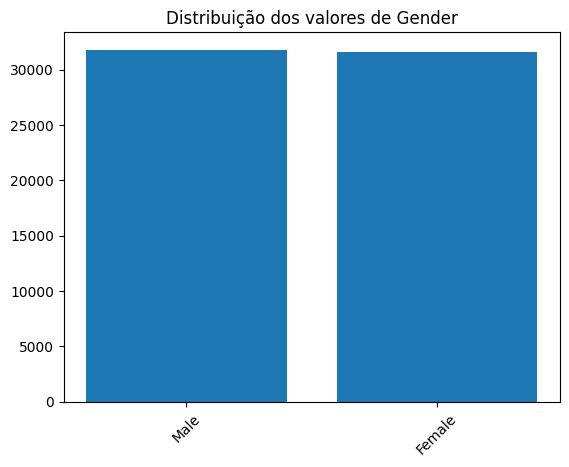

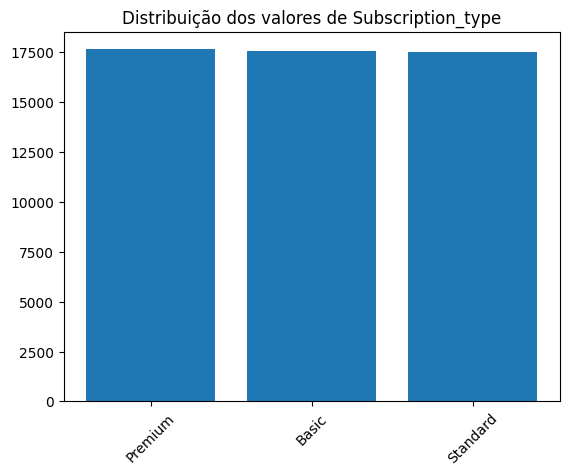

In [ ]:
# Plotando distribuições
categorical_freq_plot(df.drop(columns=['User_id']))

## Duplicatas

In [ ]:
# Procurando pela presença de duplicatas no DataFrame
df[df.duplicated()]

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
65481,23.0,Female,3628.0,NaN,NaN,3.0,4,3.21,1.0,1c9659dc-a8a0-4399-b7b9-fde8c0b6c2ca
65482,NaN,NaN,3074.0,NaN,Premium,NaN,1,4.17,0.0,7aa8544e-4932-4ed4-b764-f4e75d16fb86
65483,48.0,NaN,NaN,2.0,Premium,NaN,2,1.95,0.0,de4062f3-b21d-4b29-a4ac-5567c6571897
65484,66.0,NaN,NaN,NaN,Basic,NaN,1,1.19,0.0,143e7d7e-ac4a-4eb7-b466-96d587fd2541
65485,29.0,Female,8522.0,NaN,NaN,NaN,3,NaN,0.0,c873d227-a2c9-458d-b077-51ad913f8ae7
...,...,...,...,...,...,...,...,...,...,...
77879,45.0,Male,NaN,NaN,Basic,NaN,5,2.20,0.0,6b51fe0d-d4a1-41ed-a55c-d05f5c961e3c
77880,47.0,Female,6176.0,NaN,Premium,NaN,2,4.54,0.0,59d70167-6be0-474c-b71e-14153205b44f
77881,64.0,Female,NaN,5.0,Premium,NaN,1,4.34,1.0,a7d5ed26-78a4-4e70-bd04-0fec883e56aa
77882,58.0,Male,1314.0,5.0,Standard,NaN,4,NaN,0.0,472e9e70-87ca-4c5e-bfee-fa9f42b54f51


**Não parecem haver padrões para as duplicadas, todas as linhas com alguma duplicata não tem similaridade entre si.**

## Nulos

In [ ]:
# Tendo um primeiro contato com os nulos do DataFrame
df[df.isna().any(axis=1)]

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f
5,54.0,Male,3024.0,2.0,Basic,NaN,1,NaN,0.0,a1df3a13-9255-4d00-8a9d-20565fefaab9
...,...,...,...,...,...,...,...,...,...,...
77879,45.0,Male,NaN,NaN,Basic,NaN,5,2.20,0.0,6b51fe0d-d4a1-41ed-a55c-d05f5c961e3c
77880,47.0,Female,6176.0,NaN,Premium,NaN,2,4.54,0.0,59d70167-6be0-474c-b71e-14153205b44f
77881,64.0,Female,NaN,5.0,Premium,NaN,1,4.34,1.0,a7d5ed26-78a4-4e70-bd04-0fec883e56aa
77882,58.0,Male,1314.0,5.0,Standard,NaN,4,NaN,0.0,472e9e70-87ca-4c5e-bfee-fa9f42b54f51


In [ ]:
# Visualizando de forma ordenada os nulos por coluna
df.isna().sum().sort_values(ascending=False)

,0
Num_streaming_services,68312
Subscription_type,25221
Devices_connected,25188
Time_on_platform,21420
Avg_rating,17270
Churned,16736
Gender,14516
Age,11277
Num_active_profiles,0
User_id,0


### Analisando nulos por coluna

In [ ]:
df[df['Subscription_type'].isna()]

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
6,62.0,Female,5569.0,2.0,NaN,2.0,2,4.92,0.0,a6218fa0-84da-4bac-a7fc-ce991fdc188a
7,56.0,Male,462.0,1.0,NaN,3.0,4,3.74,1.0,9ea4f106-8533-4ee2-b7b5-31691f82b72e
8,25.0,Female,3783.0,3.0,NaN,1.0,2,2.92,0.0,2c6f08fb-82be-4e3d-b40d-6aea787c3bd5
10,56.0,Male,7258.0,5.0,NaN,NaN,3,2.37,0.0,f824a852-bda6-4174-9515-1bd2fc6df30e
16,57.0,NaN,3873.0,5.0,NaN,NaN,3,1.73,0.0,48478381-fab8-46b6-83dd-622b3f237d17
...,...,...,...,...,...,...,...,...,...,...
77862,35.0,Female,NaN,NaN,NaN,NaN,3,4.33,0.0,420bdf1d-c1c7-473b-9d92-71421f3f62da
77868,26.0,Male,NaN,2.0,NaN,NaN,4,3.81,0.0,c3374b1f-cb67-4a93-96b6-20f513270430
77872,26.0,Female,6165.0,4.0,NaN,NaN,4,NaN,0.0,b1f5ed33-9b83-4806-8f70-6de7065e6785
77875,44.0,NaN,1542.0,5.0,NaN,2.0,5,1.72,NaN,442bd9fe-60e8-4716-b3b7-acb893cff36c


In [ ]:
df[df['Devices_connected'].isna()]

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
13,NaN,Female,NaN,NaN,Standard,NaN,2,1.24,0.0,e559b809-facb-4120-8df3-45e09866842b
17,NaN,Female,2905.0,NaN,Premium,2.0,1,1.70,1.0,6f00cf5d-9fbd-43ce-a8e2-efe3f0325fb3
19,60.0,Female,8503.0,NaN,NaN,4.0,5,3.13,0.0,f19d40e0-2788-47e1-93cf-cc85b2f3f34a
23,47.0,Female,NaN,NaN,Basic,NaN,2,3.44,0.0,c6325537-975d-4baa-8edf-4ec6a07a49bb
26,37.0,Female,2922.0,NaN,Standard,NaN,3,2.45,NaN,c3ec38be-303d-4fa0-bbf5-93ba74bf83e3
...,...,...,...,...,...,...,...,...,...,...
77871,58.0,Female,NaN,NaN,Standard,NaN,2,NaN,NaN,1f7035d1-82b2-4b9d-ab05-259b04d0b264
77873,18.0,NaN,5802.0,NaN,Standard,NaN,3,3.41,NaN,8474bea4-bbf2-4f40-9e0e-026f699d8397
77874,63.0,Male,NaN,NaN,Basic,NaN,2,2.50,1.0,395e3dc6-152b-447e-b894-e729b0be8e87
77879,45.0,Male,NaN,NaN,Basic,NaN,5,2.20,0.0,6b51fe0d-d4a1-41ed-a55c-d05f5c961e3c


In [ ]:
df[df['Churned'].isna()]

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
11,61.0,Male,5389.0,3.0,Standard,NaN,4,3.92,NaN,8f62edd7-4fe0-45c2-98b9-2951e4bef897
14,44.0,Male,4198.0,1.0,Basic,NaN,3,2.59,NaN,5417ca3a-b300-4429-b227-3bc75fbb2c1d
26,37.0,Female,2922.0,NaN,Standard,NaN,3,2.45,NaN,c3ec38be-303d-4fa0-bbf5-93ba74bf83e3
33,59.0,Male,1579.0,2.0,Standard,3.0,2,2.97,NaN,283a3179-12f8-4cad-b8cb-f856e5014631
...,...,...,...,...,...,...,...,...,...,...
77866,36.0,Female,2941.0,NaN,Basic,NaN,1,3.97,NaN,77047ea4-438a-4ed7-b7bc-a4990b53b912
77871,58.0,Female,NaN,NaN,Standard,NaN,2,NaN,NaN,1f7035d1-82b2-4b9d-ab05-259b04d0b264
77873,18.0,NaN,5802.0,NaN,Standard,NaN,3,3.41,NaN,8474bea4-bbf2-4f40-9e0e-026f699d8397
77875,44.0,NaN,1542.0,5.0,NaN,2.0,5,1.72,NaN,442bd9fe-60e8-4716-b3b7-acb893cff36c


**Não parece haver padrões para os nulos, mais parecem que são erros aleatórios no sistema, exceto por 'Num_streaming_services' que tem um número exorbitante de nulos e será descartada.**

## Outliers

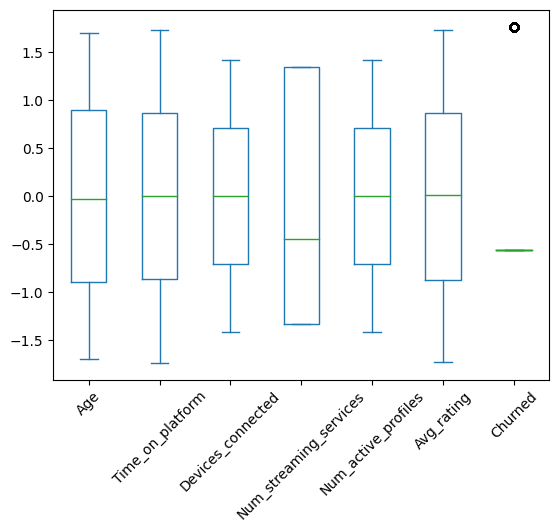

In [ ]:
# Plotando boxplots a procura de outliers
df[num_features].apply(scale).plot.box()
plt.xticks(rotation=45);

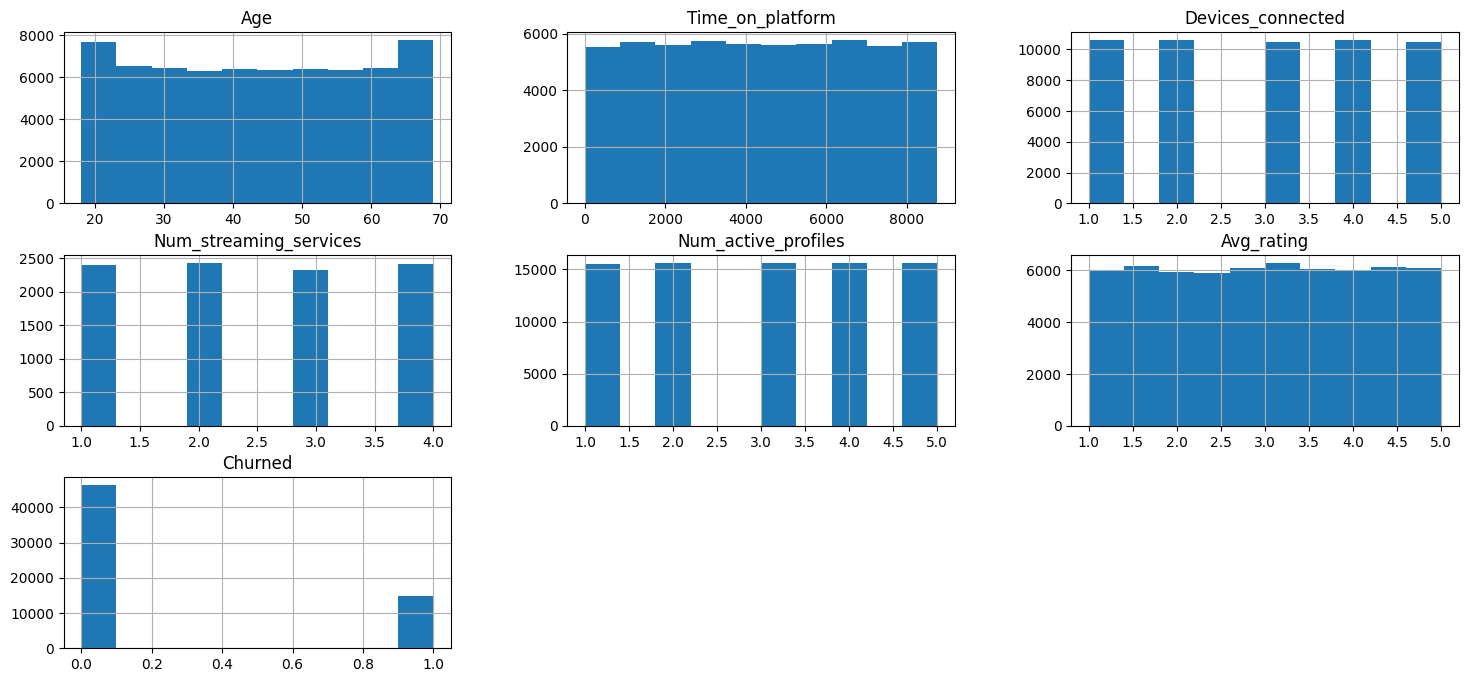

In [ ]:
# e histogramas para verificar a distribuição
df.hist(figsize=(18, 8));

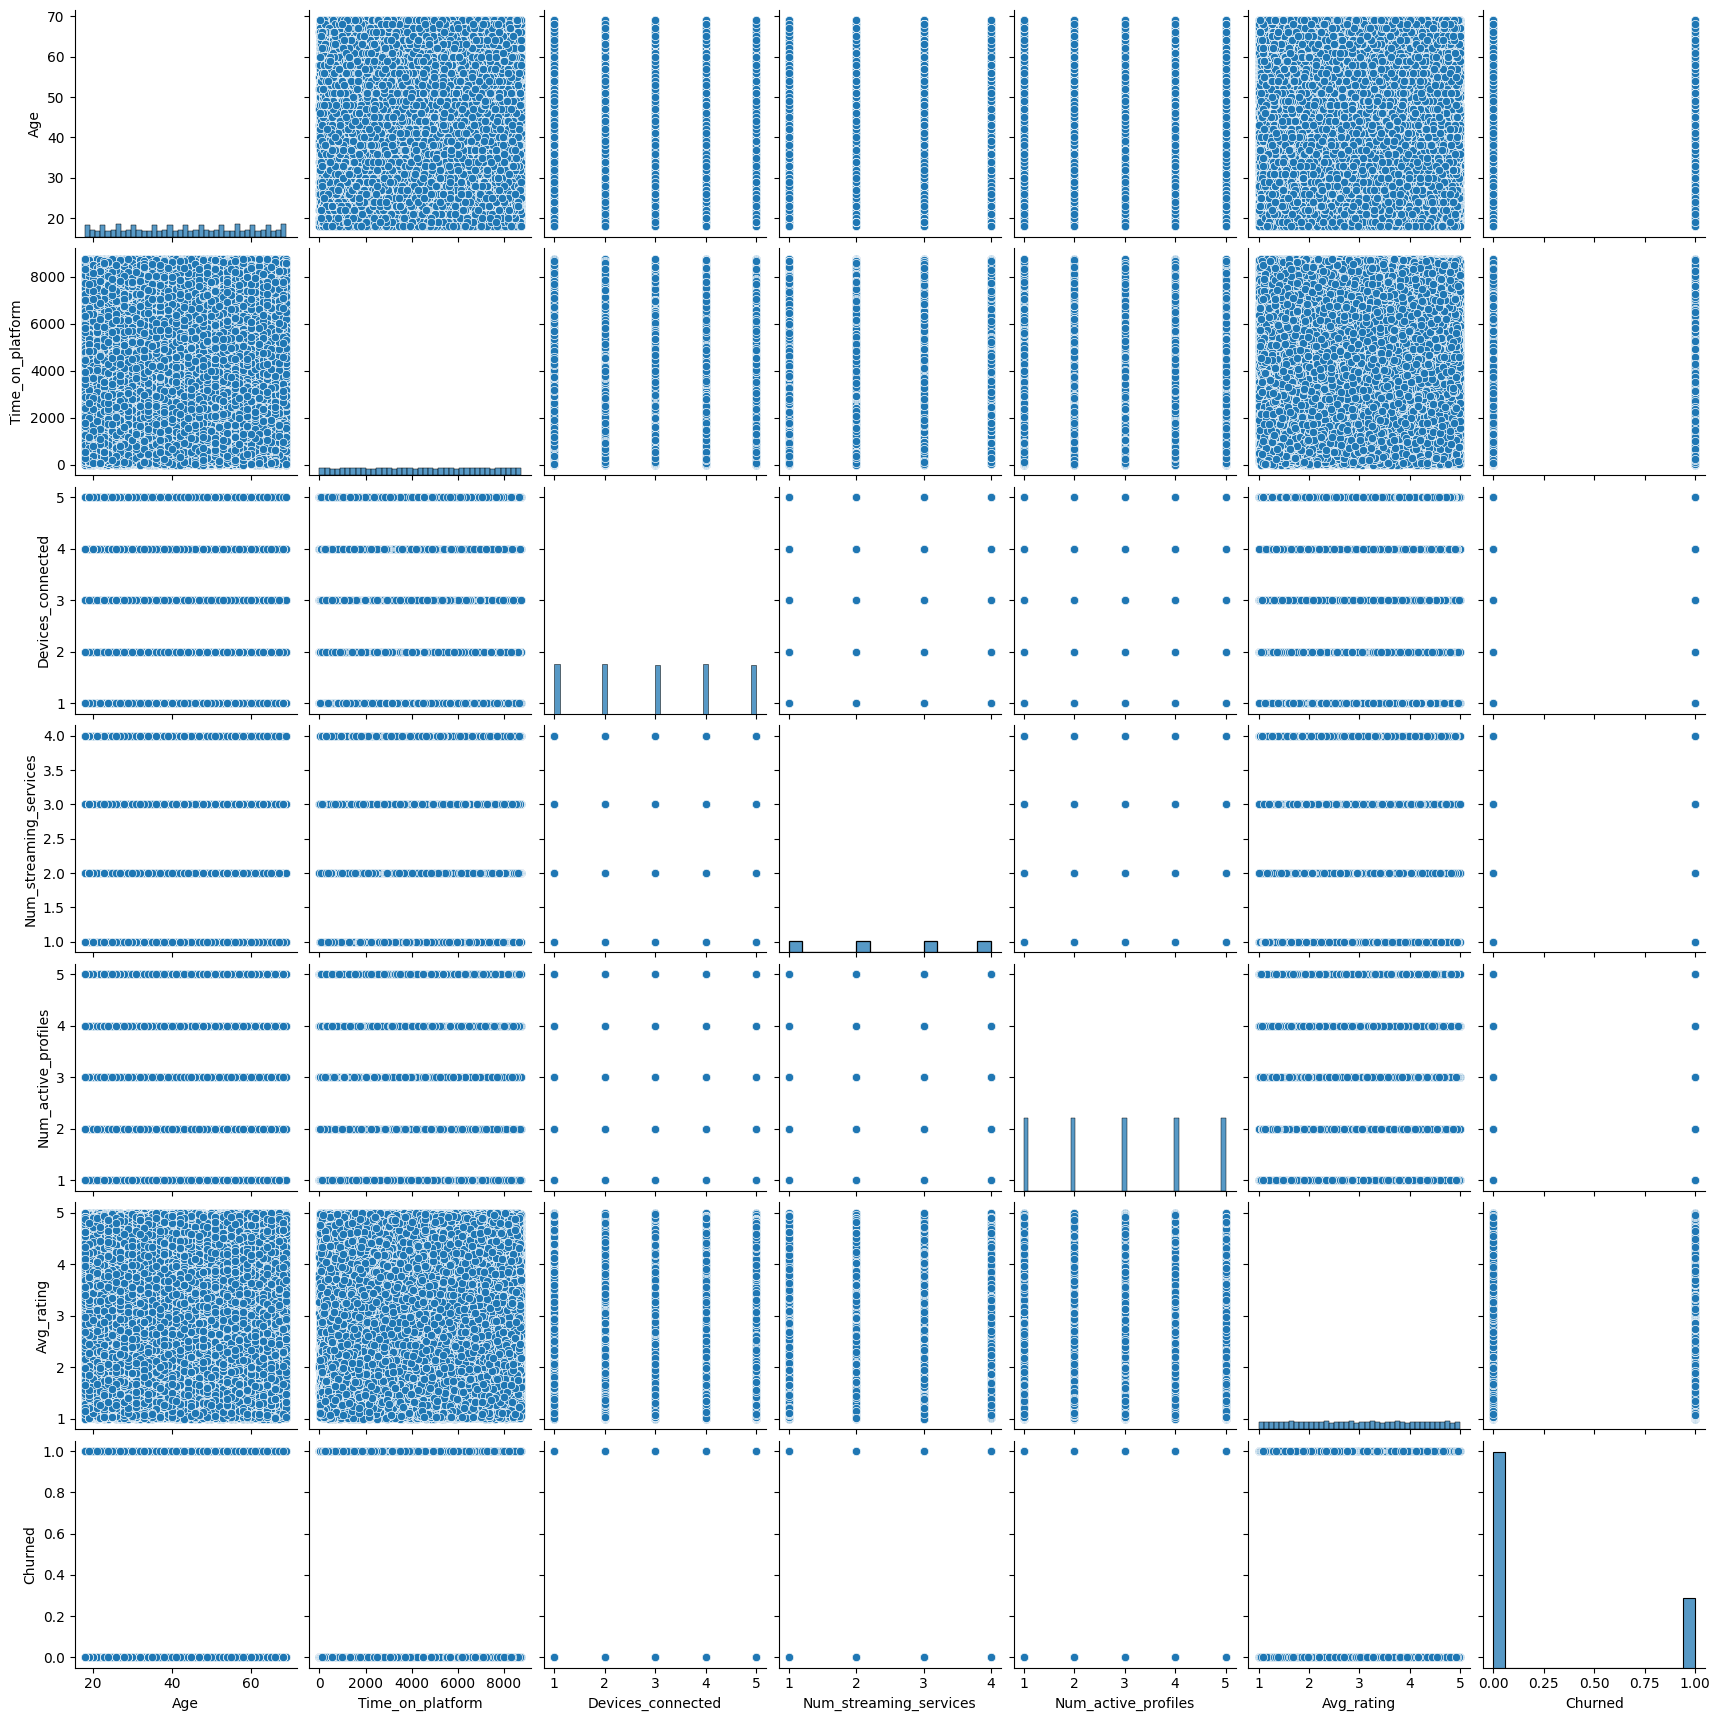

In [ ]:
# Scatterplots para a procura de alguma linearidade ou correlações complexas
sns.pairplot(df)

**Os dados tem distribuições normais, sem valores fora de seus limites IQR e sem linearidade entre as variáveis**

## Correlação linear

<Axes: >

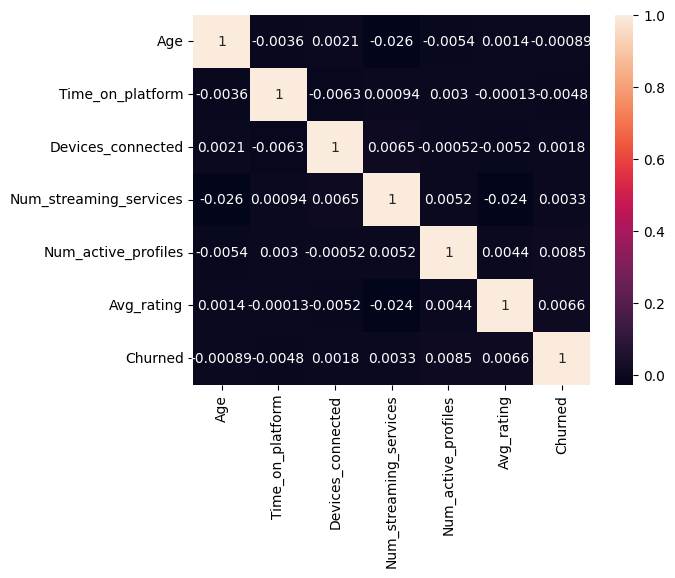

In [ ]:
# Plotando a relação linear das variáveis
sns.heatmap(df.corr(numeric_only=True), annot=True)

# Data Preparation

**Nessa etapa preparamos os dados para modelagem, tanto para assegurar a qualidade dos dados como para preparar o formato especifico para os modelos.**

## Tratamentos de qualidade

In [62]:
# Dropando 'Num_streaming_service' pela quantidade exorbitante de nulos e 'User_id' por não adicionar informação relevante
df.drop(columns=['Num_streaming_services', 'User_id'], inplace=True)

num_features = num_features.drop('Num_streaming_services')
cat_features = cat_features.drop('User_id')

In [63]:
# Dropando duplicatas inteiramente pois não há padrão nelas, e colunas como 'User_id' e 'Time_on_platform'
# são impossíveis de serem iguais na vida real

df.drop_duplicates(inplace=True)

In [64]:
# Imputando os valores com algoritimos para uma melhor qualidade nos dados
# KNNImputer para numéricas e SimpleImputer para categóricas

df[num_features] = KNNImputer().fit_transform(df[num_features])
df[cat_features] = SimpleImputer(strategy='most_frequent').fit_transform(df[cat_features])

df[['Time_on_platform', 'Age', 'Devices_connected', 'Num_active_profiles',
    'Churned']] = df[['Time_on_platform', 'Age', 'Devices_connected',
                      'Num_active_profiles', 'Churned']].astype(int)
df

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_active_profiles,Avg_rating,Churned
0,49,Male,4700,3,Basic,3,3.020,0
1,69,Female,6107,2,Standard,1,2.140,0
2,44,Male,6374,3,Premium,1,1.910,1
3,26,Male,4482,5,Basic,2,3.484,0
4,18,Male,1948,3,Basic,3,3.880,0
...,...,...,...,...,...,...,...,...
65476,60,Female,6395,2,Premium,4,2.544,1
65477,31,Male,5362,4,Premium,4,2.370,0
65478,41,Male,4654,3,Premium,4,2.652,1
65479,42,Male,5835,5,Basic,1,1.180,0


In [65]:
# Usando OneHot Encoding para features categóricas
df = pd.get_dummies(df)

In [66]:
# E StandardScaler para numéricas
features = df.drop(columns=['Churned']).columns
df[features] = StandardScaler().fit_transform(df[features])

## Undersampling

In [102]:
# Verificando por classes desbalanceadas
df['Churned'].value_counts()

,count
Churned,
0,52568
1,12525


In [112]:
indices = df.query('Churned == 0').index.to_list()
indices2drop = random.sample(indices, 30000)
df.drop(indices2drop, inplace=True)

In [113]:
df['Churned'].value_counts()

,count
Churned,
0,22568
1,12525


## Feature Importance

**Neste tópico usamos um modelo de arvore de decisão para extrair a importancia das variaveis para um modelo de classificação**

In [118]:
# Por via de classes desbalanceadas, escolhi o método StratifiedKFold para cross-validation
skf = StratifiedKFold(shuffle=True)

In [119]:
# Dividindo massas para a modelagem de feature importance
X_fi = df.drop(columns=['Churned'])
y_fi = df['Churned']

x_train_fi, x_test_fi, y_train_fi, y_test_fi = train_test_split(X_fi, y_fi, test_size=.3, random_state=42)

In [120]:
# Criando modelo de classificação
model = DecisionTreeClassifier()
model.fit(x_train_fi, y_train_fi)

DecisionTreeClassifier()

In [121]:
# Utilizando a função 'cross_avaliate' para realizar a validação cruzada no modelo e retornar as métricas em um DataFrame
cross_avaliate([model], X_fi, y_fi, skf, score_type=['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])

,Models,roc_auc,accuracy,balanced_accuracy,precision,recall,f1
0,DecisionTreeClassifier,0.50828,0.544439,0.509065,0.36405,0.376846,0.37018


In [122]:
# Visualizando a Feature Importance com a função 'feature_importance_tree'
fi = feature_importance_tree(model, X_fi.columns)
fi

,Features,Importance
0,Time_on_platform,0.328609
1,Avg_rating,0.295092
2,Age,0.154958
3,Devices_connected,0.074917
4,Num_active_profiles,0.068715
5,Subscription_type_Standard,0.022090
6,Subscription_type_Premium,0.019591
7,Subscription_type_Basic,0.018928
8,Gender_Male,0.009008
9,Gender_Female,0.008092


In [123]:
# Criando uma lista para as features que serão dropadas de acordo com sua importância
columns2drop = fi.query('Importance < 0.1')['Features'].unique()

In [124]:
# Dividindo novas massas sem as features sem importância
X_fi = X_fi.drop(columns=columns2drop)

x_train_fi, x_test_fi, y_train_fi, y_test_fi = train_test_split(X_fi, y_fi, test_size=.3, random_state=42)

In [125]:
# Treinando um novo modelo
model = DecisionTreeClassifier()
model.fit(x_train_fi, y_train_fi)

DecisionTreeClassifier()

In [126]:
# Avaliando-o
cross_avaliate([model], X_fi, y_fi, skf, score_type=['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])

,Models,roc_auc,accuracy,balanced_accuracy,precision,recall,f1
0,DecisionTreeClassifier,0.508871,0.548514,0.515459,0.374589,0.380359,0.375232


In [127]:
# Feature Importance
fi = feature_importance_tree(model, X_fi.columns)
fi

,Features,Importance
0,Time_on_platform,0.455834
1,Avg_rating,0.382055
2,Age,0.162111


# Modelling

**Nesta etapa finalmente damos inicio a modelagem, criando modelos capazes de prever se o cliente deixará o streaming ou não.**

## Dividindo massas para modelagem

In [128]:
X = df[['Time_on_platform', 'Avg_rating', 'Age']]
y = df['Churned']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

## Criando e avaliando modelos

In [129]:
# Modelo de Árvore de decisão (DecisionTree)
DT_class = DecisionTreeClassifier()
DT_class.fit(x_train, y_train)

# Modelo de ensemble bagging (RandomForest)
RF_class = RandomForestClassifier()
RF_class.fit(x_train, y_train)

# Modelo de ensemble boosting (GradientBoosting)
GB_class = GradientBoostingClassifier()
GB_class.fit(x_train, y_train)

# Modelo de K vizinhos próximos (KNN)
KNN = KNeighborsClassifier()
KNN.fit(x_train, y_train)

# Modelo de máquinas vetores de suporte (SVM)
SVM = SVC()
SVM.fit(x_train, y_train)

# Modelo de rede neural (MPL)
neural = MLPClassifier(max_iter=500, hidden_layer_sizes=(100, 50, 20))
neural.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50, 20), max_iter=500)

In [130]:
# Criando um novo objeto de StratifiedKfold para diminuir o número de folds para a validação cruzada
skf = StratifiedKFold(shuffle=True, n_splits=3)

In [131]:
# Avaliando os modelos, porém mesmo com o Undersampling alguns modelos não conseguiram predizer positivos
# o que leva a 0 em algumas métricas

cross_avaliate([DT_class, RF_class, GB_class, KNN, SVM, neural], X, y, skf, ['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

,Models,roc_auc,accuracy,balanced_accuracy,precision,recall,f1
0,RandomForestClassifier,0.519180,0.593737,0.512910,0.380804,0.219481,0.282725
1,KNeighborsClassifier,0.513522,0.580657,0.505053,0.363977,0.258523,0.296221
2,DecisionTreeClassifier,0.511287,0.551705,0.508086,0.371881,0.379960,0.379311
3,GradientBoostingClassifier,0.502762,0.642122,0.500219,0.365091,0.003992,0.006326
4,SVC,0.499725,0.643091,0.500000,0.000000,0.000000,0.000000
5,MLPClassifier,0.494923,0.637164,0.499889,0.071429,0.001996,0.012765


DecisionTreeClassifier:

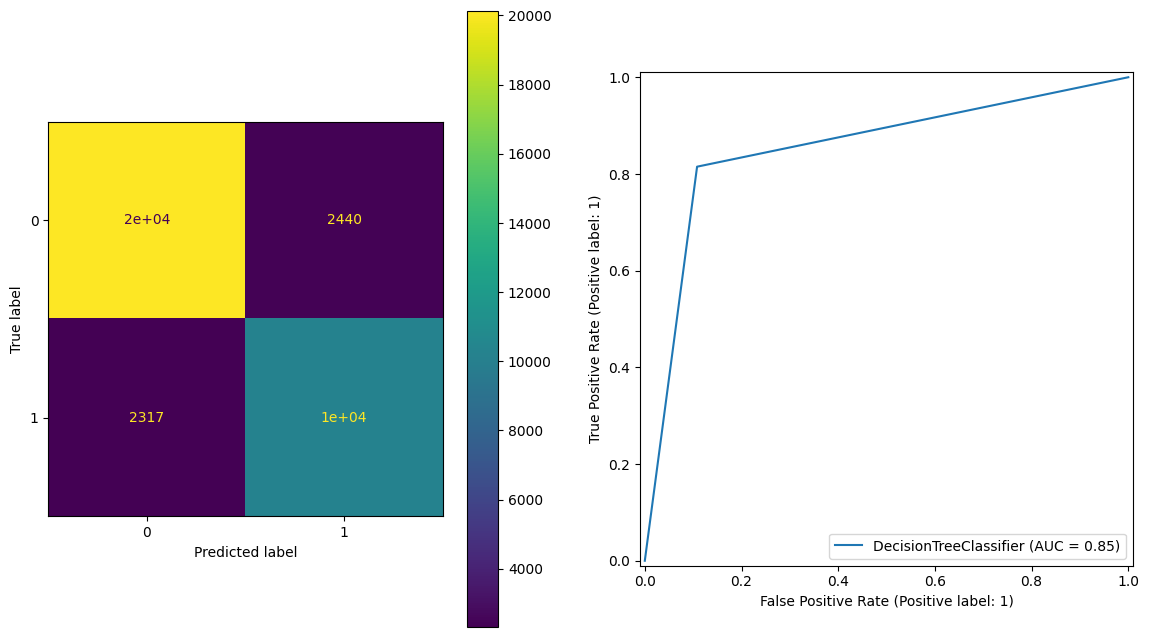

RandomForestClassifier:

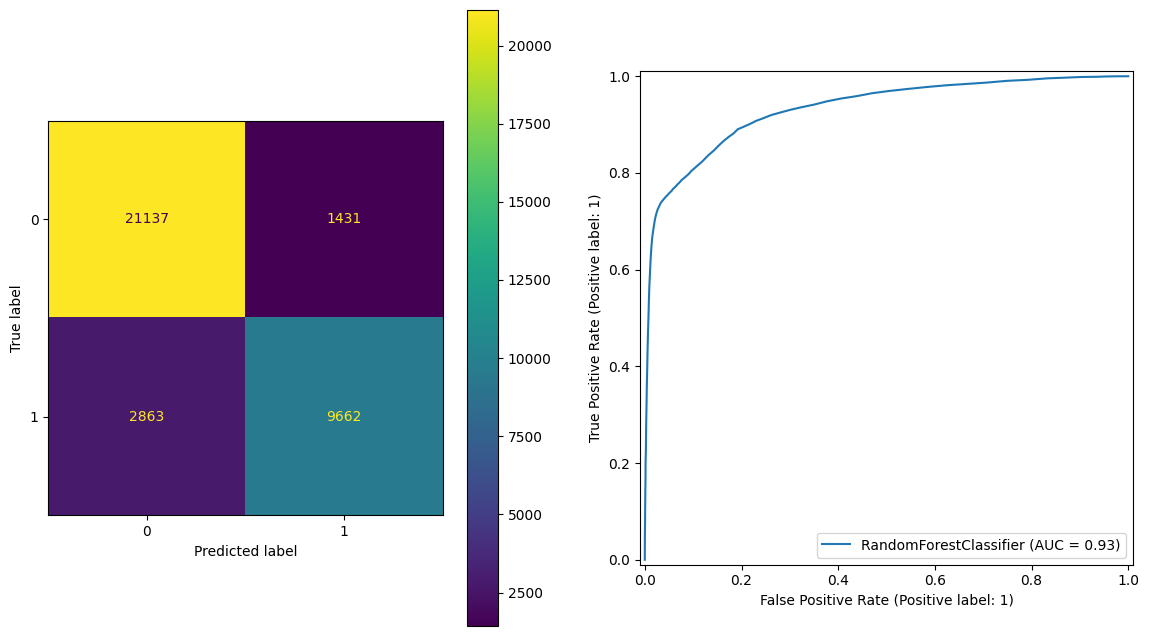

GradientBoostingClassifier:

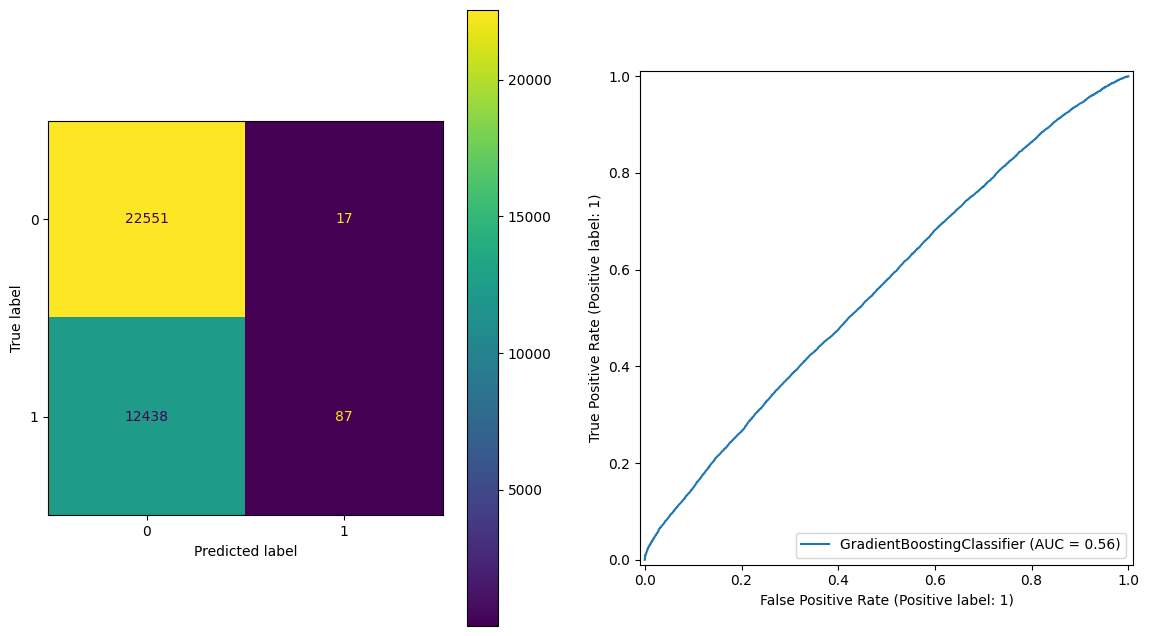

KNeighborsClassifier:

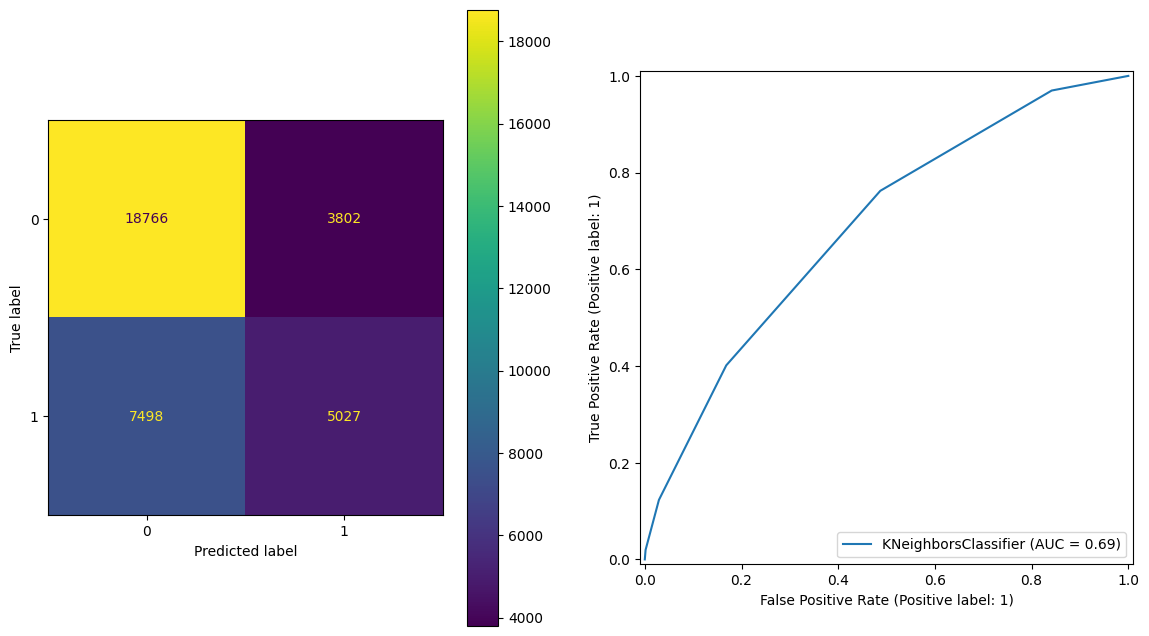

SVC:

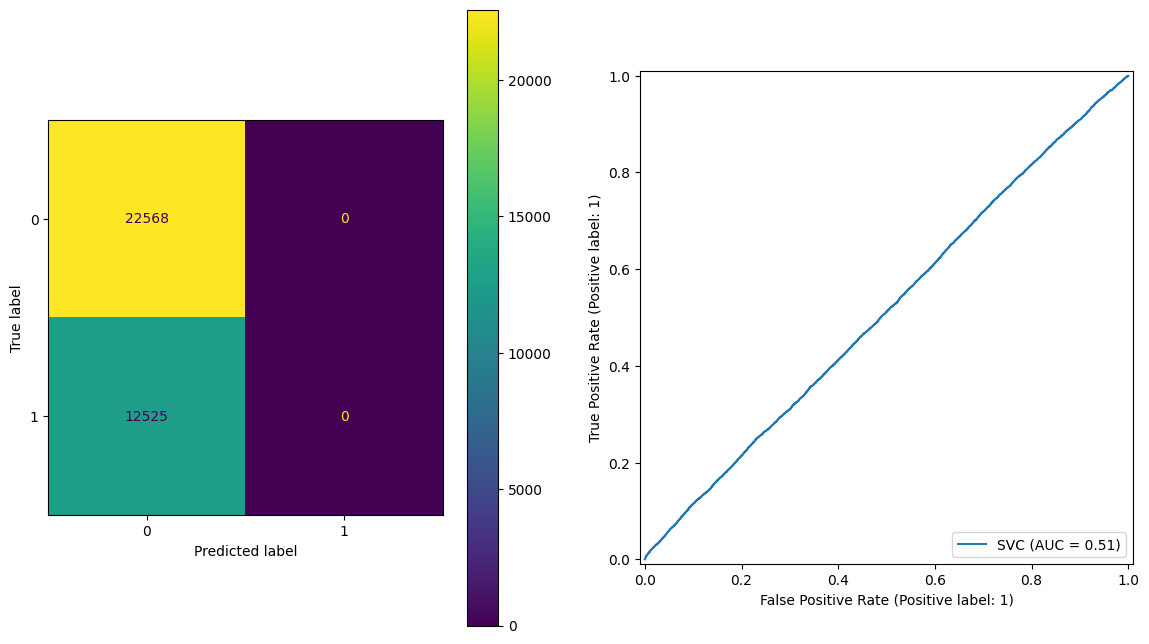

MLPClassifier:

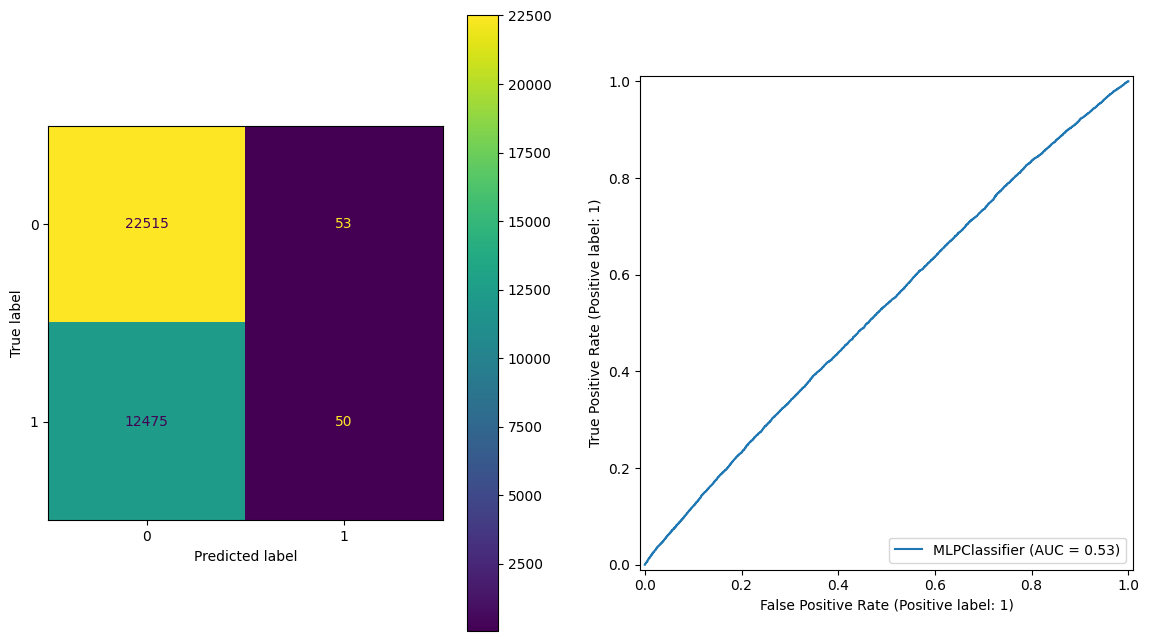

In [132]:
# Plotando matrizes de confusão e Curvas ROC para cada modelo.
classification_plots([DT_class, RF_class, GB_class, KNN, SVM, neural], X, y)

## Otimização de HiperParâmetros

**Foram Escolhidos os 3 melhores na avaliação de Cross-Validation para a otimização**

**tunnando e avaliando modelos**

In [133]:
# Utilizando RandomizedSearchCV para realizar a busca, pois o conjunto de dados é extenso e não tenho
# Unidades computacionais suficientes par uma busca mais precisa

param_search([RF_class, KNN, DT_class], [
    {
        'max_depth': [3, 5, 7, 9],
        'min_samples_split': [2, 3, 4, 5],
        'min_samples_leaf': [1, 2, 3, 4],
        'max_features': ['sqrt', 'log2', 0.2, 0.3],
        'bootstrap': [False, True],
        'n_estimators': [100, 150, 200, 250]
    },

    {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    },

    {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [3, 5, 7, 9],
        'min_samples_split': [2, 3, 4, 5],
        'min_samples_leaf': [1, 2, 3, 4],
        'max_features': ['sqrt', 'log2', 0.2, 0.3],
        'random_state': [42]
    }
], RandomizedSearchCV, X, y, n_iter=15)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,Models,Avaliation,Adjusted Parameters
0,KNeighborsClassifier,0.525411,"{'algorithm': 'kd_tree', 'n_neighbors': 7, 'weights': 'distance'}"
1,RandomForestClassifier,0.504511,"{'max_depth': 9, 'max_features': 0.2, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 250}"
2,DecisionTreeClassifier,0.504120,"{'max_depth': 7, 'max_features': 0.3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'random_state': 42}"


In [140]:
# Criando os modelos com os parâmetros de acordo com a busca
RF_class_tunned = RandomForestClassifier(
    max_features=0.2,
    max_depth=9,
    min_samples_leaf=3,
    min_samples_split=4,
    n_estimators=250
)
RF_class_tunned.fit(x_train, y_train)

DT_class_tunned = DecisionTreeClassifier(
    max_depth=7,
    max_features=0.3,
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42
)
DT_class_tunned.fit(x_train, y_train)

KNN_tunned = KNeighborsClassifier(
    algorithm='kd_tree',
    n_neighbors=7,
    weights='distance'
)
KNN_tunned.fit(x_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7, weights='distance')

In [138]:
# Avaliando-os
cross_avaliate([RF_class_tunned, DT_class_tunned, KNN_tunned], X, y, skf, ['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])

,Models,roc_auc,accuracy,balanced_accuracy,precision,recall,f1
0,KNeighborsClassifier,0.521748,0.582509,0.510131,0.382323,0.260998,0.307111
1,RandomForestClassifier,0.500024,0.642892,0.500040,0.236111,0.000719,0.000955
2,DecisionTreeClassifier,0.498852,0.641951,0.500097,0.336758,0.011098,0.015379


RandomForestClassifier:

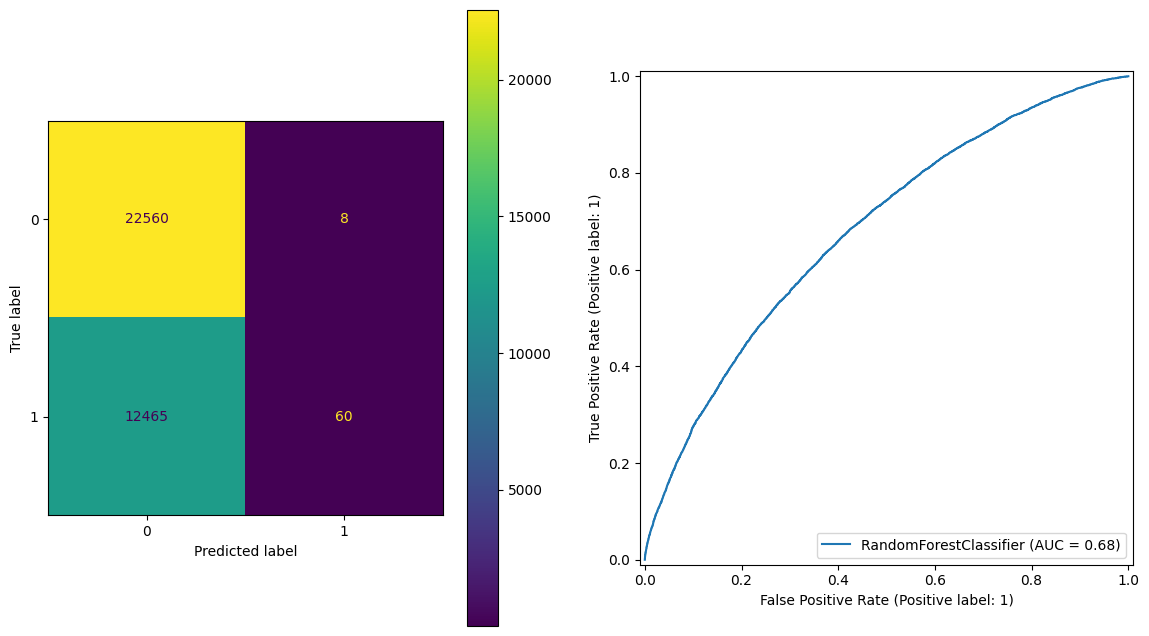

DecisionTreeClassifier:

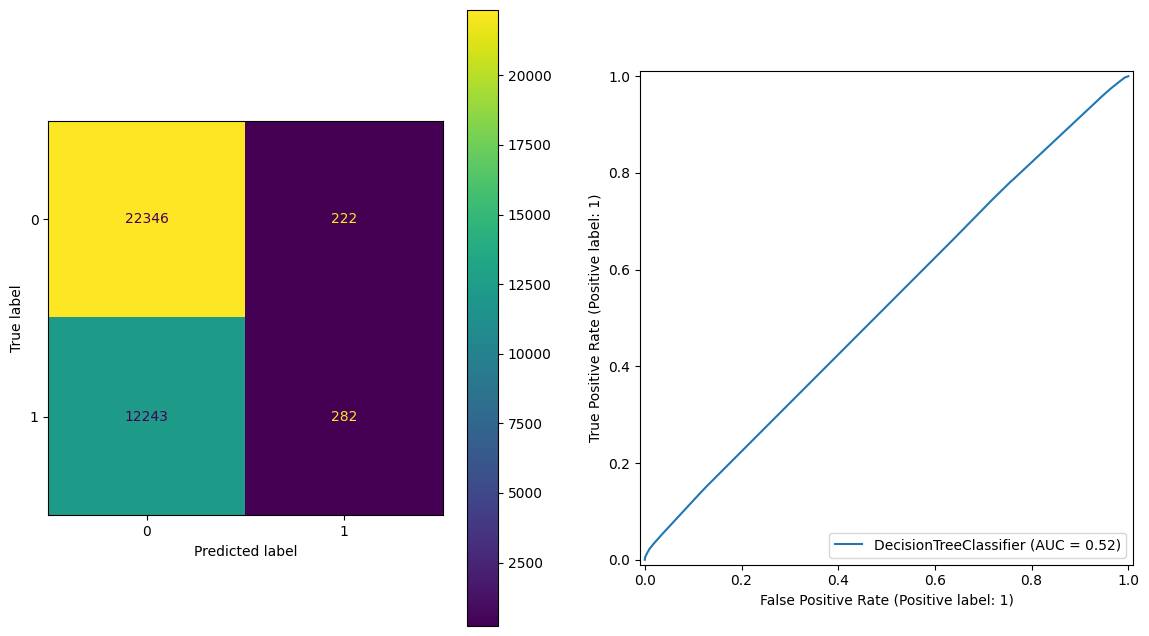

KNeighborsClassifier:

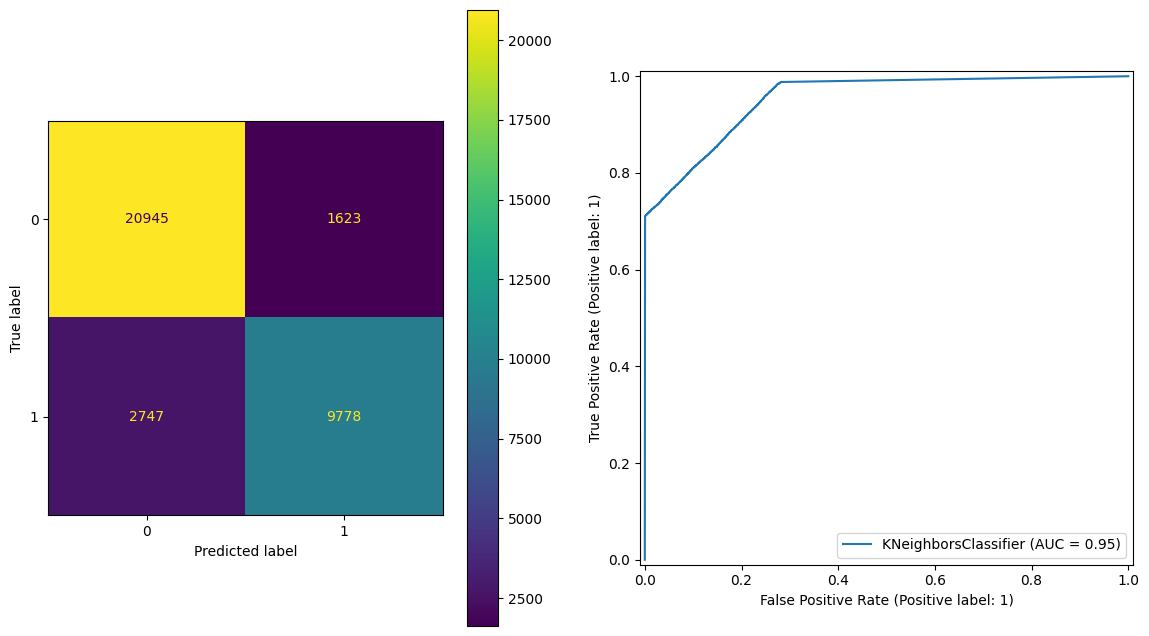

In [141]:
# Plotando matriz de confusão e Curvas ROC
classification_plots([RF_class_tunned, DT_class_tunned, KNN_tunned], X, y)

# Interpretabilidade do modelo

**O melhor modelo na validação cruzada pós otimização de HiperParametros recebe neste tópico uma visão mais interna, mostrando seu processo de decisão. Que no nosso caso foi o 'KNeighborsClassifier'.**

In [ ]:
# criando um indice aleatório, para que sempre que executado, mostre uma linha diferente e consequentemente uma nova
# predição
random_idx = np.random.randint(0, len(X))

# Criando o Explainer e plotando-o
explainer = LimeTabularExplainer(X.to_numpy(), training_labels=y, feature_names=X.columns, class_names=['No', 'Yes'])
exp = explainer.explain_instance(X.to_numpy()[random_idx], KNN_tunned.predict_proba)
exp.show_in_notebook()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
